In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import re, os
import unicodedata
import json

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import acquire
import prepare_jag

import spacy
pd.set_option('display.max_colwidth', None)



### Acquire data

We will be using the 1000 labeled notes in `test.csv`

In [2]:
df = prepare_jag.prep_train()

Test, notes, and features loaded.
Merged dataframes
Renamed 'pn_history' column to 'original'
Added a basic clean column lowercaseing and removing special characters
Added stemmed column with tokenized words and stopwords removed
Added lemmatized column with lemmatized words and stopwords removed
Data preparation complete


In [3]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beating/pounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes vision/hearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights / week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                   

In [4]:
df.shape

(14300, 11)

---

In [5]:
df.case_num.value_counts().sort_index()

0    1300
1    1300
2    1700
3    1600
4    1000
5    1800
6    1200
7     900
8    1800
9    1700
Name: case_num, dtype: int64

In [6]:
# Look at distribution of cases
cases = pd.concat([df.case_num.value_counts().sort_index(), df.case_num.value_counts(normalize = True)], axis = 1)
cases.columns = ['n', 'percent']
cases

n   percent
0  1300  0.090909
1  1300  0.090909
2  1700  0.118881
3  1600  0.111888
4  1000  0.069930
5  1800  0.125874
6  1200  0.083916
7   900  0.062937
8  1800  0.125874
9  1700  0.118881

<AxesSubplot:title={'center':'Case Representation'}, ylabel='n'>

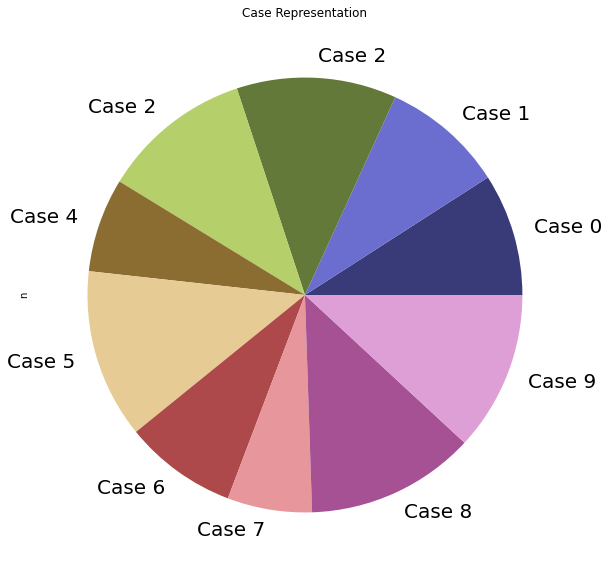

In [7]:
cases.n.plot.pie(
    figsize=[10,10], 
    title='Case Representation',
    labels=['Case 0', 'Case 1','Case 2','Case 2','Case 4','Case 5','Case 6','Case 7','Case 8','Case 9',],
    fontsize=20,
    cmap='tab20b'
    )

Make word lists by case from cleaned words



In [8]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beating/pounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes vision/hearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights / week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                   

In [9]:
#Make word lists by case_num_xs from clean words
case0_words = ' '.join(df[df.case_num == 0].clean).split()
case1_words = ' '.join(df[df.case_num == 1].clean).split()
case2_words = ' '.join(df[df.case_num == 2].clean).split()
case3_words = ' '.join(df[df.case_num == 3].clean).split()
case4_words = ' '.join(df[df.case_num == 4].clean).split()
case5_words = ' '.join(df[df.case_num == 5].clean).split()
case6_words = ' '.join(df[df.case_num == 6].clean).split()
case7_words = ' '.join(df[df.case_num == 7].clean).split()
case8_words = ' '.join(df[df.case_num == 8].clean).split()
case9_words = ' '.join(df[df.case_num == 9].clean).split()
all_words = ' '.join(df.clean).split()


In [10]:
# Look at word list lengths
print('Case0 words: '+str(len(case0_words)))
print('Case1 words: '+str(len(case1_words)))
print('Case2 words: '+str(len(case2_words)))
print('Case3 words: '+str(len(case3_words)))
print('Case4 words: '+str(len(case4_words)))
print('Case5 words: '+str(len(case5_words)))
print('Case6 words: '+str(len(case6_words)))
print('Case7 words: '+str(len(case7_words)))
print('Case8 words: '+str(len(case8_words)))
print('Case9 words: '+str(len(case9_words)))
print('All words: '+str(len(all_words)))

Case0 words: 123994
Case1 words: 125918
Case2 words: 174437
Case3 words: 151280
Case4 words: 92630
Case5 words: 174006
Case6 words: 114888
Case7 words: 92376
Case8 words: 181890
Case9 words: 147628
All words: 1379047


In [11]:
# Calculate word frequencies
case0_freq = pd.Series(case0_words).value_counts()
case1_freq = pd.Series(case1_words).value_counts()
case2_freq = pd.Series(case2_words).value_counts()
case3_freq = pd.Series(case3_words).value_counts()
case4_freq = pd.Series(case4_words).value_counts()
case5_freq = pd.Series(case5_words).value_counts()
case6_freq = pd.Series(case6_words).value_counts()
case7_freq = pd.Series(case7_words).value_counts()
case8_freq = pd.Series(case8_words).value_counts()
case9_freq = pd.Series(case9_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [12]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, case0_freq, case1_freq, case2_freq, case3_freq, case4_freq, case5_freq, case6_freq, case7_freq, case8_freq, case9_freq], axis = 1, sort = True)
                .set_axis(['all', 'Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case8', 'Case9'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(50)

all  Case0  Case1  Case2  Case3  Case4  Case5  Case6  Case7  \
no            44445   3419   4615   5780   5888   2660   6264   2820   3384   
pain          24512    793   4966   1445   7248    530   1044   4380    792   
none          17780   1729   2132   1224   1936   1340   3654   1008   1773   
denies        17746   1807   1508   2193   1600   1570   2088   1584   1089   
ago           16863   1248   2652   2720    848    630   4122    780   1287   
2             12248    715   1456   2295   2352    430   2088    216   1440   
last          11461   1820   1898   2652    528    290   1512    732   1197   
-              9681    585    663   1054   1328    570   1116   1044    612   
pmh            9660    871    780   1224   1072    700   1116    840    621   
weeks          9316     39    949    476    704   1130   3186      0    279   
months         9138   1430   1417   1394   1456     60    810    204   2331   
changes        9119   1118    351   1598    608    930   1206    408    702   
3              8889    338    208   2397    192    190   1980    204    360   
days           8754    702   1469   2703     16    120    540   1068   1008   
use            8753   1027    923    799    992    640   1188   1008    702   
ros            8328    754    689    850   1056    650   1026    816    513   
meds           7328    689    715    884    816    440    882    600    531   
past           7322    546   1209    833    576    390   1008    420    945   
patient        7103    533    689    799   1072    410   1170    612    396   
active         7026    754    858   1037    688    370    864    684    594   
chest          6773   1690    156    238    544    330    972   2052     90   
fh             6702    637    546    799    928    460    774    576    423   
years          6446     65      0   2448    640     70   1296     96    576   
sexually       6356    598    793    952    672    340    810    588    549   
yo             6319    663    598    748    736    500    684    564    477   
sh             6278    546    572    714    768    480    774    492    441   
history        6217    416    572    867    496    330   1008    564    486   
allergies      6096    546    559    748    640    400    720    600    432   
episodes       5941   1430    715    119    272    230   2484     72      0   
periods        5881      0    221   3536      0    120     90      0   1863   
also           5832    468    377    782    672    550    630    504    342   
reports        5826    299    377    629    592    420    648    408    432   
week           5746    780     39    952   1200    430    612    156     27   
nausea         5528    234    676    459   1248    110   1188    300    144   
psh            5303    403    416    544    624    360    666    468    333   
day            5276    169    572    680    752    330    720    432    450   
f              5255     13    780    799      0    480    702     60    549   
hx             5175    663    507    680    624    310    702    420    279   
weight         5121    520    312    765    528    490    792    276    441   
drinks         4912   1196    416    408    352    420     36    396    189   
nkda           4869    429    481    493    576    310    594    480    243   
year           4811    598    299   1207    480    260    612    204    333   
since          4730    260    507    204    848    230    486    360    144   
pt             4682    520    390    510    512    260    360    432    270   
1              4622    338    169    935    720    260    378    504    270   
palpitations   4557    702     65    119    128    500   2538    240     54   
negative       4526    455    442    527    528    220    702    396    261   
headache       4418    195    104    170    144    290    234    168     81   
presents       4377    364    364    442    432    300    702    324    306   
worse          4333    247    806     85    848    300    468    5

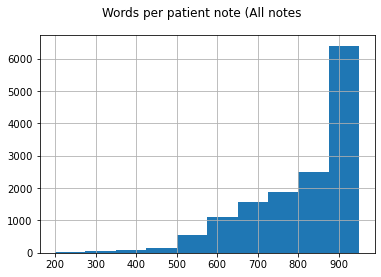

In [56]:
df['original'].str.len().hist()
plt.suptitle('Words per patient note (All notes');


In [61]:
# Add original word count to df
df['original_word_count']=df.original.apply(lambda x: len(str(x).split(' ')))

In [64]:
import warnings
warnings.filterwarnings("ignore")

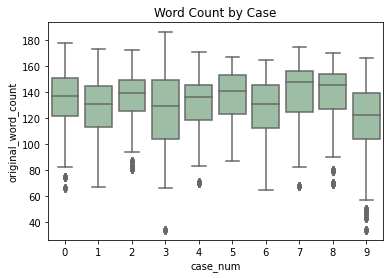

In [67]:
ax = sns.boxplot(x='case_num', y='original_word_count', data=df, color='#99c2a2')
#ax = sns.swarmplot(x="case_num", y="original_word_count", data=df, color='#7d0013')
plt.title('Word Count by Case')
plt.show();

H0: there is no difference in mean word length by case
HA: there is a difference

Distributions of word counts are not normal, so need non-parametric test. Ust Kruskal-Wallis

In [71]:
df[df.case_num==0].original_word_count

0       142
1       113
2       155
3       152
4       111
       ... 
1295    120
1296    120
1297    132
1298    153
1299    157
Name: original_word_count, Length: 1300, dtype: int64

In [73]:
from scipy import stats


In [74]:
stats.kruskal(
    df[df.case_num==0].original_word_count,
    df[df.case_num==1].original_word_count,
    df[df.case_num==2].original_word_count,
    df[df.case_num==3].original_word_count,
    df[df.case_num==4].original_word_count,
    df[df.case_num==5].original_word_count,
    df[df.case_num==6].original_word_count,
    df[df.case_num==7].original_word_count,
    df[df.case_num==8].original_word_count,
    df[df.case_num==9].original_word_count,
)

KruskalResult(statistic=933.8786503284377, pvalue=3.0963892141290268e-195)

In [75]:
from scipy.stats import alexandergovern


In [77]:
stats.alexandergovern(
    df[df.case_num==0].original_word_count,
    df[df.case_num==1].original_word_count,
    df[df.case_num==2].original_word_count,
    df[df.case_num==3].original_word_count,
    df[df.case_num==4].original_word_count,
    df[df.case_num==5].original_word_count,
    df[df.case_num==6].original_word_count,
    df[df.case_num==7].original_word_count,
    df[df.case_num==8].original_word_count,
    df[df.case_num==9].original_word_count,
)

AlexanderGovernResult(statistic=838.0707538143807, pvalue=1.352431175764315e-174)

In [78]:
from scipy.stats import f_oneway


In [79]:
stats.f_oneway(
    df[df.case_num==0].original_word_count,
    df[df.case_num==1].original_word_count,
    df[df.case_num==2].original_word_count,
    df[df.case_num==3].original_word_count,
    df[df.case_num==4].original_word_count,
    df[df.case_num==5].original_word_count,
    df[df.case_num==6].original_word_count,
    df[df.case_num==7].original_word_count,
    df[df.case_num==8].original_word_count,
    df[df.case_num==9].original_word_count,
)

F_onewayResult(statistic=110.18199977281415, pvalue=1.2045874162420276e-200)

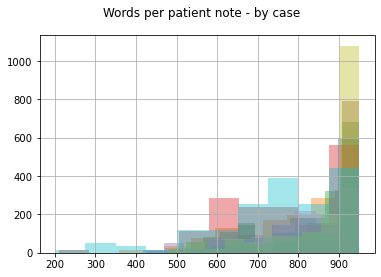

In [59]:
df[df['case_num']==0].original.str.len().hist(alpha=0.4)
df[df['case_num']==1].original.str.len().hist(alpha=0.4)
df[df['case_num']==2].original.str.len().hist(alpha=0.4)
df[df['case_num']==3].original.str.len().hist(alpha=0.4)
df[df['case_num']==4].original.str.len().hist(alpha=0.4)
df[df['case_num']==5].original.str.len().hist(alpha=0.4)
df[df['case_num']==6].original.str.len().hist(alpha=0.4)
df[df['case_num']==7].original.str.len().hist(alpha=0.4)
df[df['case_num']==8].original.str.len().hist(alpha=0.4)
df[df['case_num']==9].original.str.len().hist(alpha=0.4)
plt.suptitle('Words per patient note - by case');


In [60]:
fig = px.box(df, y="total_bill")
fig.show()

df[df['case_num']==0]

id  case_num  pn_num  feature_num  \
0     00016_000         0      16            0   
1     00041_000         0      41            0   
2     00046_000         0      46            0   
3     00082_000         0      82            0   
4     00100_000         0     100            0   
...         ...       ...     ...          ...   
1295  02315_012         0    2315           12   
1296  02425_012         0    2425           12   
1297  02428_012         0    2428           12   
1298  02430_012         0    2430           12   
1299  02436_012         0    2436           12   

                                                         feature_text  \
0     Family-history-of-MI-OR-Family-history-of-myocardial-infarction   
1     Family-history-of-MI-OR-Family-history-of-myocardial-infarction   
2     Family-history-of-MI-OR-Family-history-of-myocardial-infarction   
3     Family-history-of-MI-OR-Family-history-of-myocardial-infarction   
4     Family-history-of-MI-OR-Family-history-of-myocardial-infarction   
...                                                               ...   
1295                                                             Male   
1296                                                             Male   
1297                                                             Male   
1298                                                             Male   
1299                                                             Male   

                            annotation     location  \
0     ['dad with recent heart attcak']  ['696 724']   
1                                   []           []   
2             ['father: heart attack']  ['824 844']   
3                        ['Father MI']  ['622 631']   
4                           ['Dad-MI']  ['735 741']   
...                                ...          ...   
1295                             ['M']      ['6 7']   
1296                                []           []   
1297                          ['male']    ['27 31']   
1298                          ['male']    ['25 29']   
1299                          ['male']    ['38 42']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      original  \
0                       HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, end

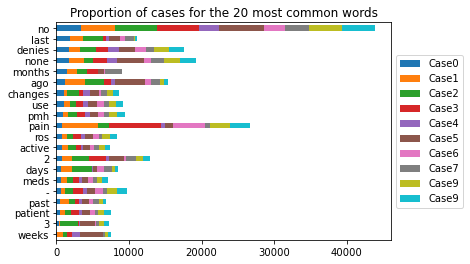

In [13]:
# figure out the percentage of language in words
(word_counts
 .assign(p_case0 = word_counts.Case0 / word_counts['all'],
        p_case1 = word_counts.Case1 / word_counts['all'],
        p_case2 = word_counts.Case2 / word_counts['all'],
        p_case3 = word_counts.Case3 / word_counts['all'],
        p_case4 = word_counts.Case4 / word_counts['all'],
        p_case5 = word_counts.Case5 / word_counts['all'],
        p_case6 = word_counts.Case6 / word_counts['all'],
        p_case7 = word_counts.Case7 / word_counts['all'],
        p_case8 = word_counts.Case8 / word_counts['all'],
        p_case9 = word_counts.Case9 / word_counts['all'])
        
 .sort_values(by = 'all')
 [['Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case9', 'Case9']]
 .tail(20)
 .sort_values('Case0')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of cases for the 20 most common words');

### Look at bigrams by case

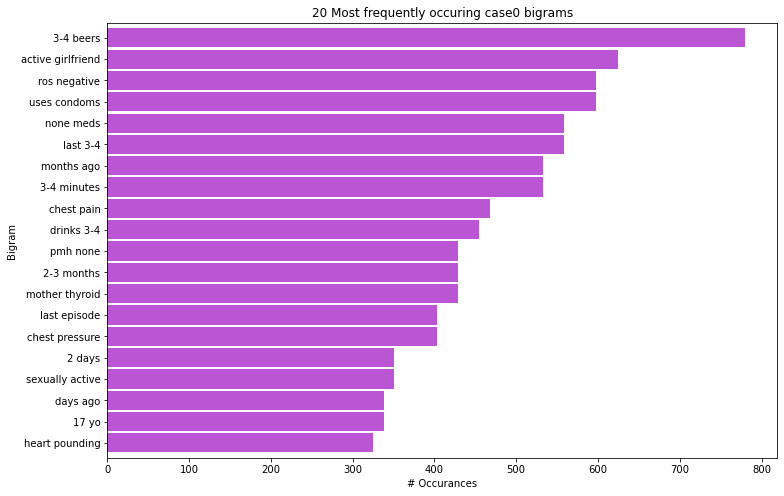

In [14]:
# Calculate Case 0bigrams
case0_bigrams = (pd.Series(nltk.ngrams(case0_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case0 Bigrams
case0_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case0 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case0_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

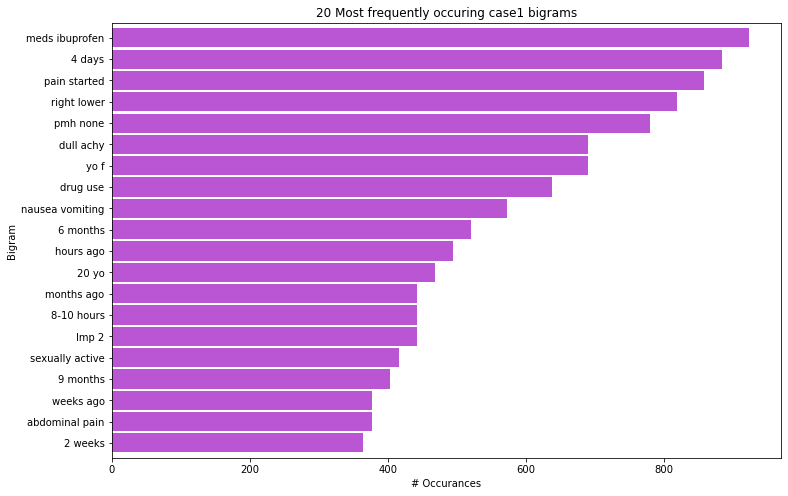

In [15]:
# Calculate Case 1 bigrams
case1_bigrams = (pd.Series(nltk.ngrams(case1_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case1 Bigrams
case1_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case1 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case1_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

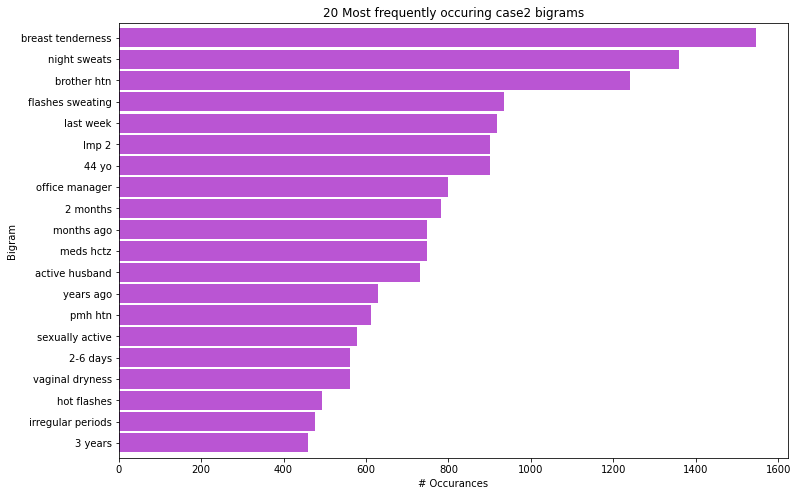

In [16]:
# Calculate Case 2 bigrams
case2_bigrams = (pd.Series(nltk.ngrams(case2_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case2 Bigrams
case2_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case2 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case2_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

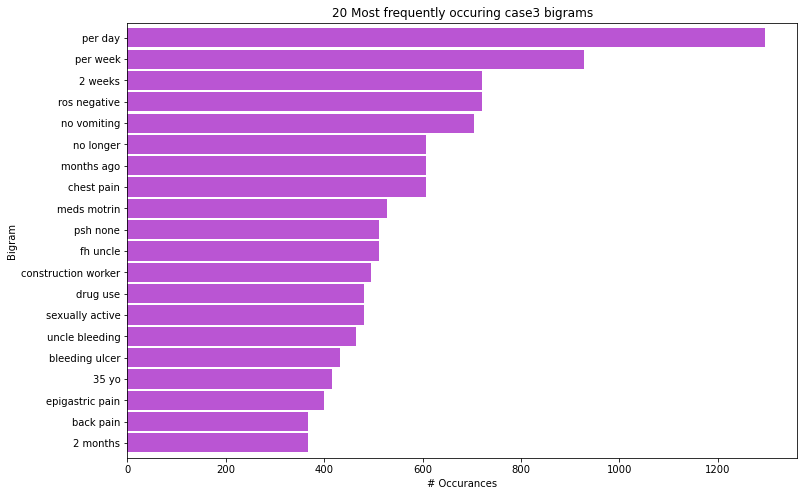

In [17]:
# Calculate Case 3 bigrams
case3_bigrams = (pd.Series(nltk.ngrams(case3_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case3 Bigrams
case3_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case3 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case3_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

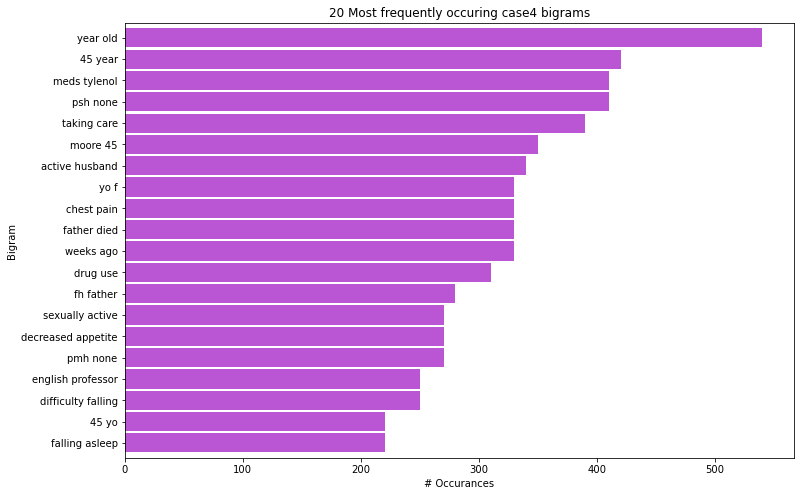

In [18]:
# Calculate Case 4 bigrams
case4_bigrams = (pd.Series(nltk.ngrams(case4_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case4 Bigrams
case4_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case4 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case4_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

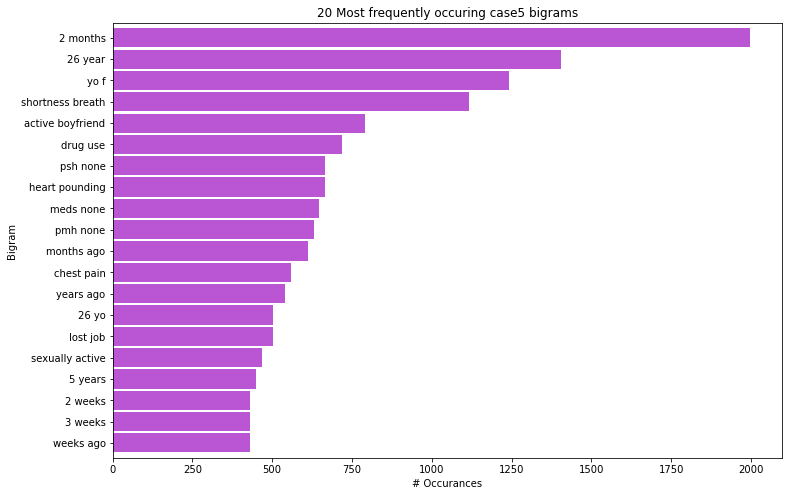

In [19]:
# Calculate Case 5bigrams
case5_bigrams = (pd.Series(nltk.ngrams(case5_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case5 Bigrams
case5_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case5 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case5_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

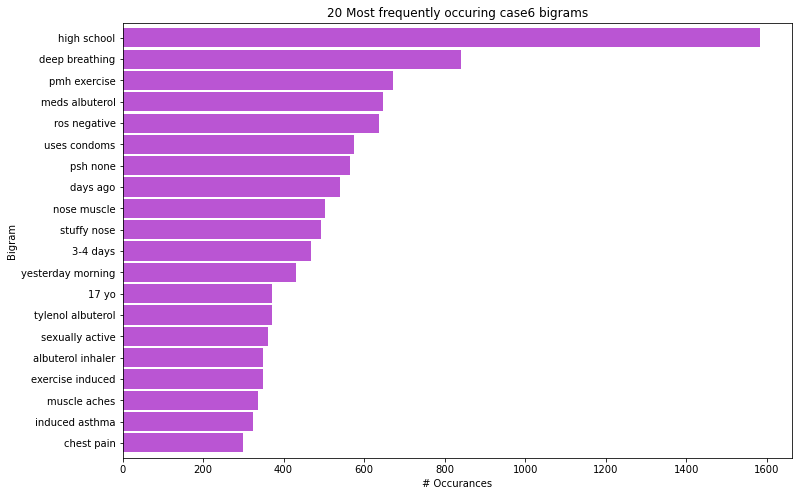

In [20]:
# Calculate Case 6 bigrams
case6_bigrams = (pd.Series(nltk.ngrams(case6_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case6 Bigrams
case6_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case6 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case6_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

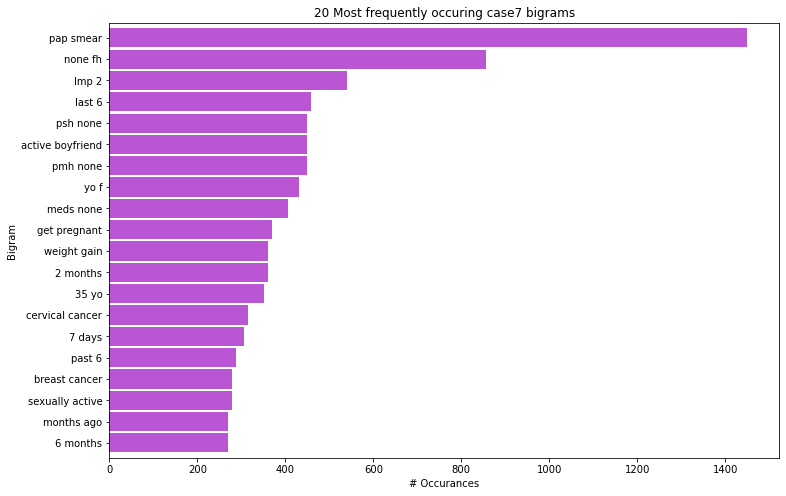

In [21]:
# Calculate Case 7 bigrams
case7_bigrams = (pd.Series(nltk.ngrams(case7_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case7 Bigrams
case7_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case7 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case7_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

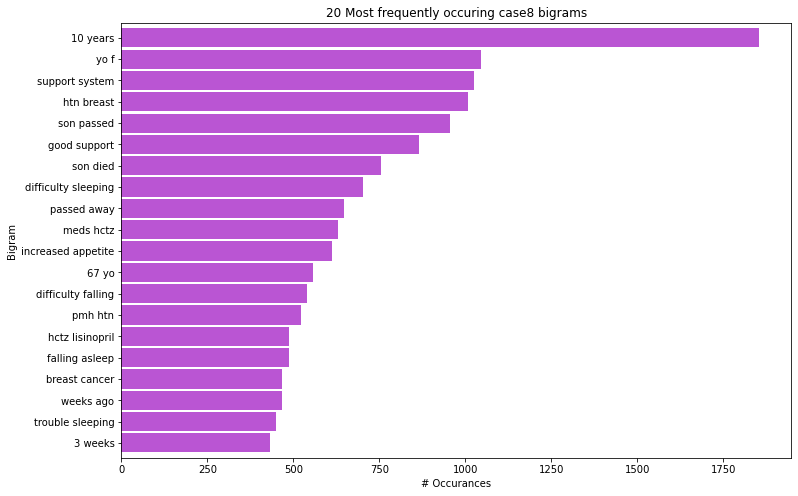

In [22]:
# Calculate Case 8 bigrams
case8_bigrams = (pd.Series(nltk.ngrams(case8_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case8 Bigrams
case8_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case8 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case8_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

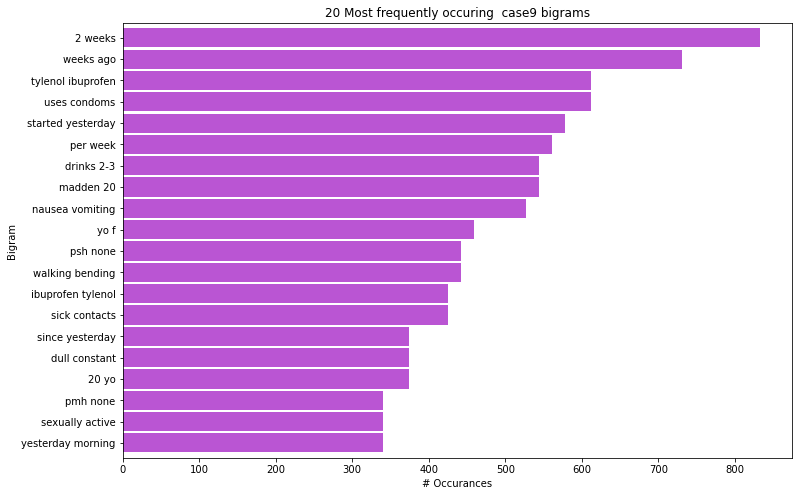

In [23]:
# Calculate Case 9 bigrams
case9_bigrams = (pd.Series(nltk.ngrams( case9_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top  case9 Bigrams
case9_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring  case9 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels =  case9_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

[ ] Trigrams?

---

### Word Clouds

In [24]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'white', height = 1600, width = 800).generate(' '.join(all_words))
case0_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case0_words))
case1_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case1_words))
case2_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case2_words))
case3_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case3_words))
case4_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case4_words))
case5_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case5_words))
case6_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case6_words))
case7_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case7_words))
case8_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case8_words))
case9_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case9_words))



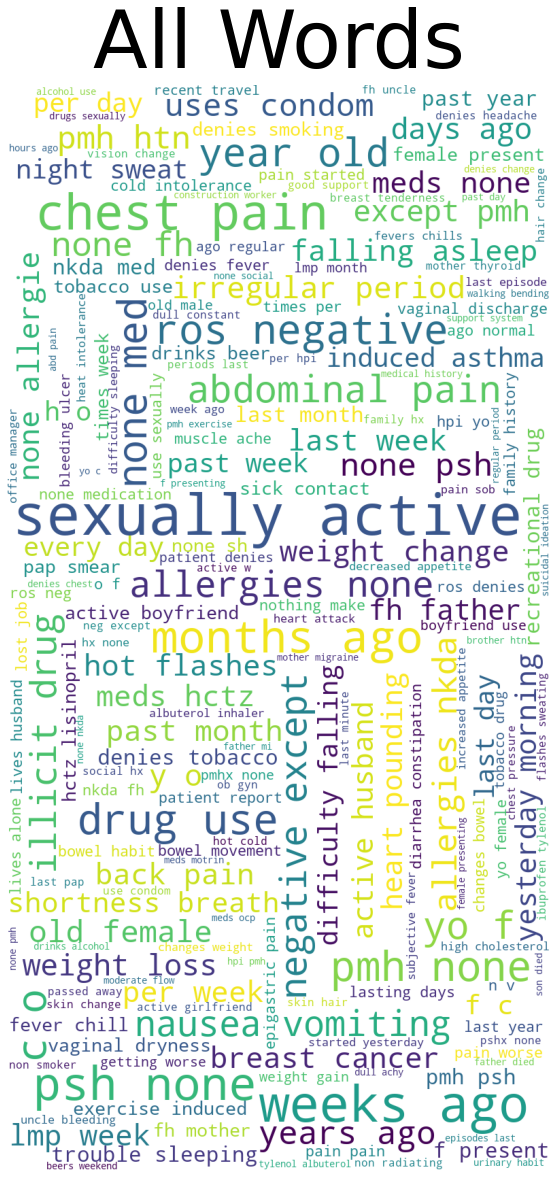

In [25]:
plt.figure(figsize = (10, 20))
plt.imshow(all_cloud);
plt.title('All Words', fontsize=80)
plt.axis('off');

(-0.5, 799.5, 799.5, -0.5)

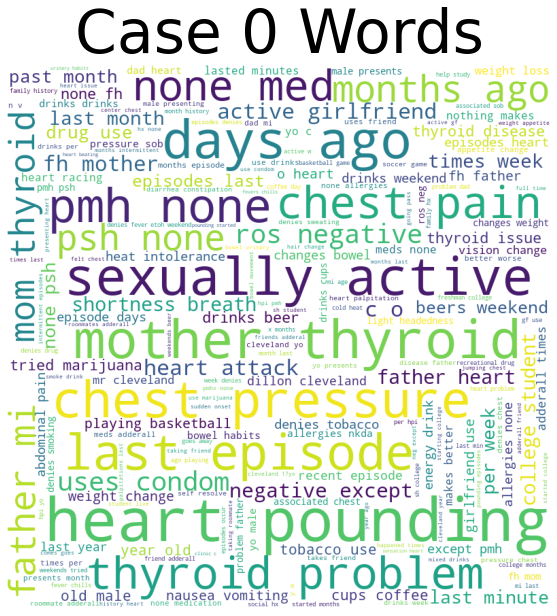

In [26]:
plt.figure(figsize = (10, 10))
plt.imshow(case0_cloud);
plt.title('Case 0 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

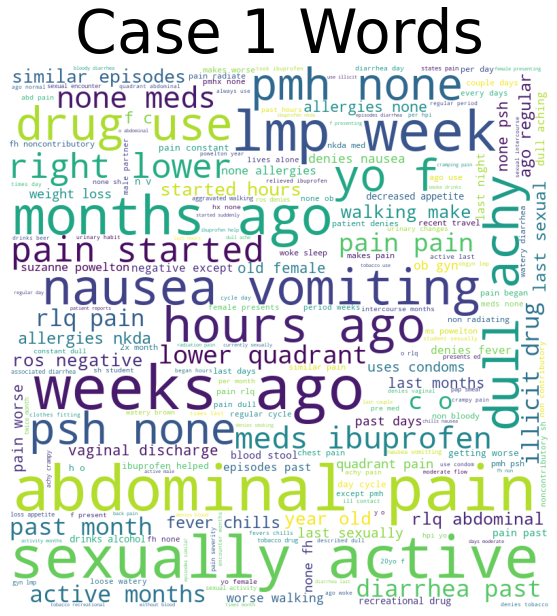

In [27]:
plt.figure(figsize = (10, 10))
plt.imshow(case1_cloud);
plt.title('Case 1 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

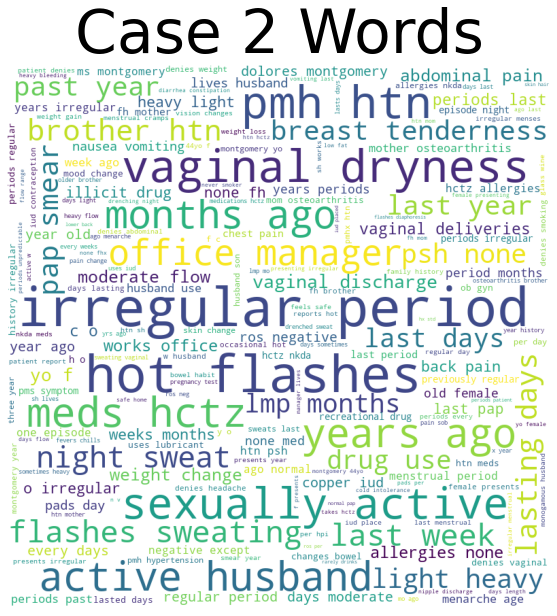

In [28]:
plt.figure(figsize = (10, 10))
plt.imshow(case2_cloud);
plt.title('Case 2 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

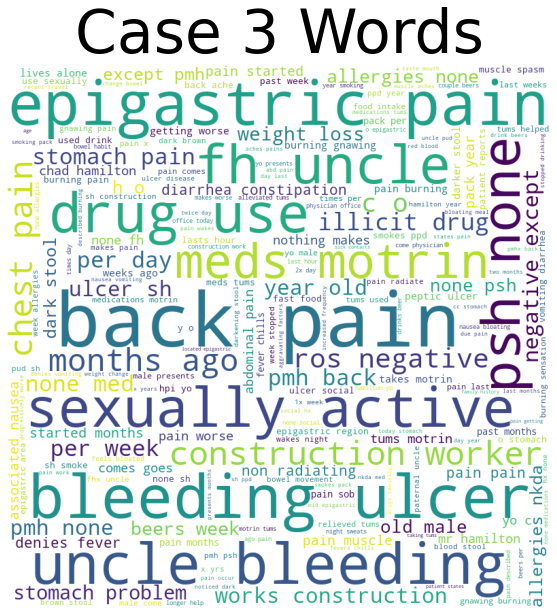

In [29]:
plt.figure(figsize = (10, 10))
plt.imshow(case3_cloud);
plt.title('Case 3 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

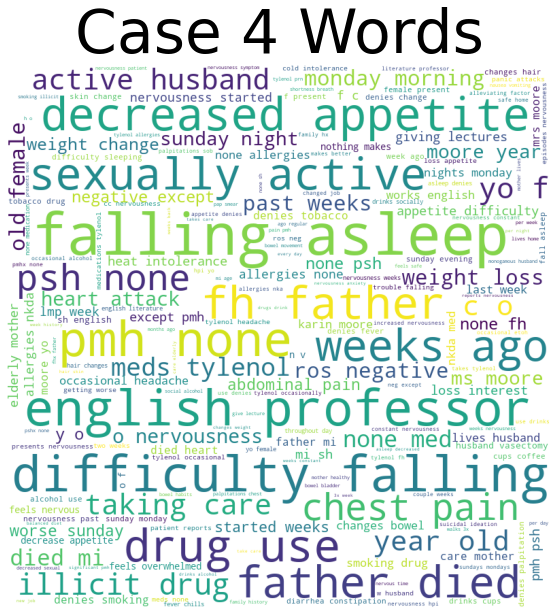

In [30]:
plt.figure(figsize = (10, 10))
plt.imshow(case4_cloud);
plt.title('Case 4 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

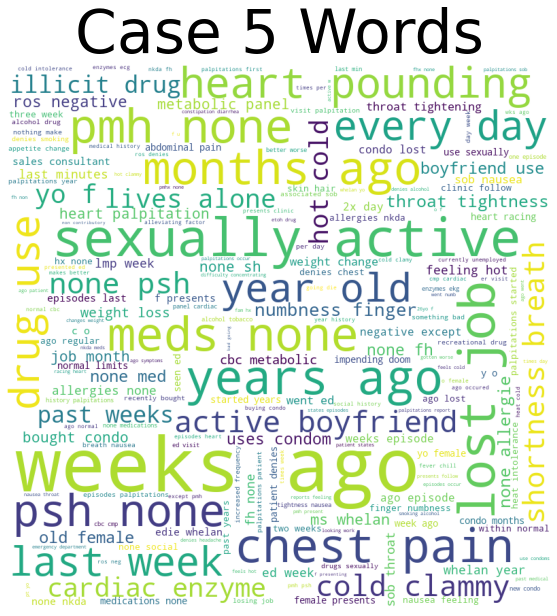

In [31]:
plt.figure(figsize = (10, 10))
plt.imshow(case5_cloud);
plt.title('Case 5 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

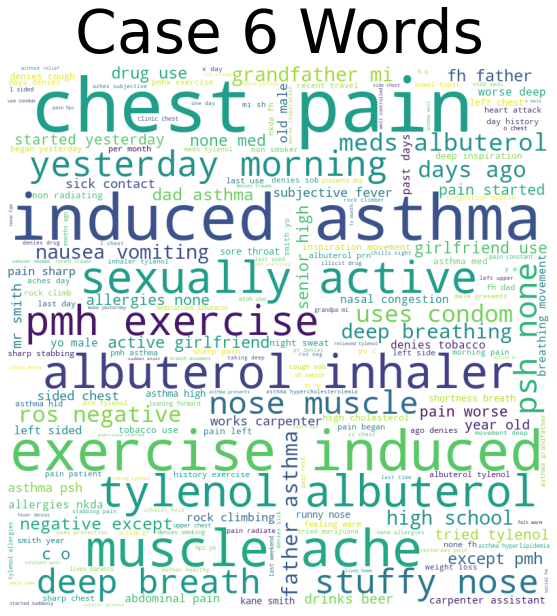

In [32]:
plt.figure(figsize = (10, 10))
plt.imshow(case6_cloud);
plt.title('Case 6 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

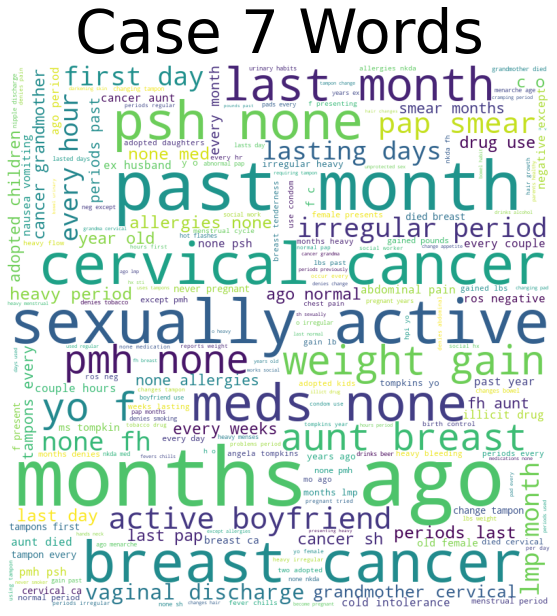

In [33]:
plt.figure(figsize = (10, 10))
plt.imshow(case7_cloud);
plt.title('Case 7 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

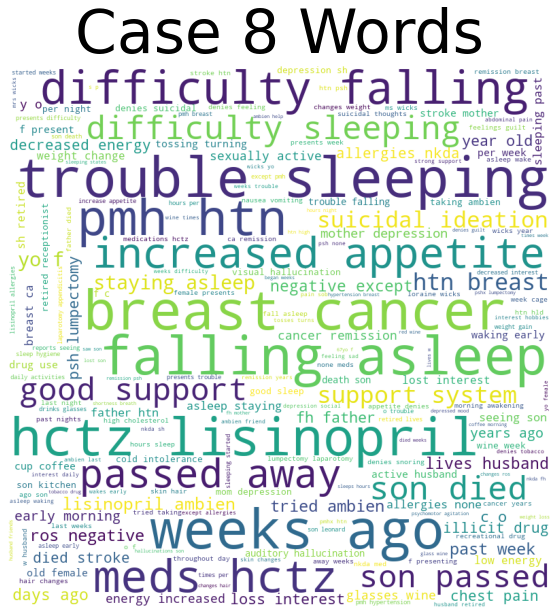

In [34]:
plt.figure(figsize = (10, 10))
plt.imshow(case8_cloud);
plt.title('Case 8 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

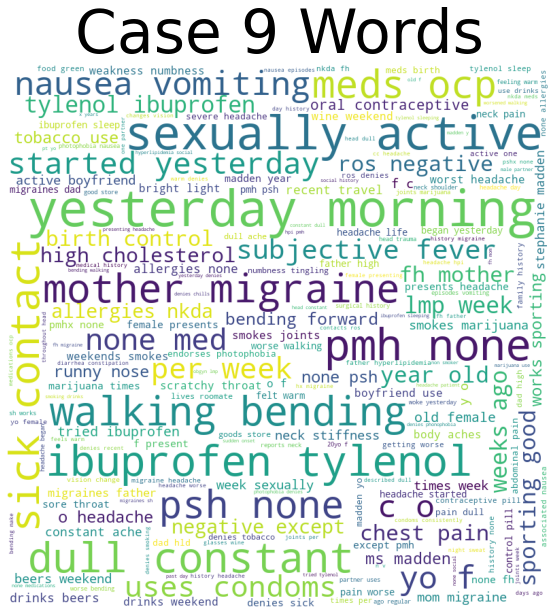

In [35]:
plt.figure(figsize = (10, 10))
plt.imshow(case9_cloud);
plt.title('Case 9 Words', fontsize=60)
plt.axis('off')
